In [3]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os
import torch
import numpy as np
import pytorch3d.io as p3dio
from easydict import EasyDict
from functools import partial

from graphic_utils import *
from optim_utils import *

device = torch.device("cuda:0")
if not os.path.exists("./cache"):
    os.makedirs("./cache")
    
paths = ['/home/huzhanhao/data/cache/objs/Man_whole/Man_join/man.obj',
        '/home/huzhanhao/data/cache/objs/Man_whole/tshirt_join/tshirt.obj',
        '/home/huzhanhao/data/cache/objs/Man_whole/trouser_join/trouser.obj']

mesh_man, mesh_tshirt, mesh_trouser = [p3dio.load_objs_as_meshes([path], device=device) for path in paths]
print('Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


## tshirt

### def

In [33]:
def loc_init_front_back(locations, device):
    # initialize the locations for front&back
    locations[:, 0] = locations[:, 0] - locations[:, 0].mean()
    locations[:, 1] = locations[:, 1] - locations[:, 1].min()
    theta0 = np.pi / 2 * 0.95
    R = locations[:, 0].max() / theta0
    theta =  locations[:, 0] / R

    R = 10.0 - locations[:, 1]
    # R = R ** 0.5

    gamma = 1.3
    R0 = R.min() ** gamma
    R1 = R.max() ** gamma
    r0 = torch.tensor(0.5, device=device) ** gamma
    r1 = torch.tensor(4.0, device=device) ** gamma
    b = R0 - (R1 - R0) / (r1/r0 -1)
    a = r0 / (R0 - b)
    r = (a * (R**gamma - b)) ** (1 / gamma)
    locations = torch.stack([r * theta.sin(), r * theta.cos()], 1)
    locations_ori = locations.clone()
    return locations, locations_ori

def loc_init_sleeves(locations, device):
    # initialize the locations for sleeves
    locations[:, 0] = locations[:, 0] - locations[:, 0].mean()
    locations[:, 1] = locations[:, 1] - locations[:, 1].min()
    theta0 = np.pi * 0.95
    # locations[:, 0] *= (locations[:, 1] + 0.2)
    m = (locations[0] + locations[75]).abs()[0] / 2
    a = (locations[0] - locations[75]).abs()[0] / 2 / theta0
    b = ((locations[25] - locations[50]).abs()[0] / 2 / theta0 - a) / (locations[25] - locations[0]).abs()[1]
    R = a + locations[:, 1] * b 
    theta =  (locations[:, 0] - m) / R
    # r = a * (R^2 - R0^2) ^ 1/2
    gamma = 0.7
    R0 = R.min() ** gamma
    R1 = R.max() ** gamma
    r0 = torch.tensor(0.5, device=device) ** gamma
    r1 = torch.tensor(4.0, device=device) ** gamma
    b = R0 - (R1 - R0) / (r1/r0 -1)
    a = r0 / (R0 - b)
    r = (a * (R**gamma - b)) ** (1 / gamma)
    locations = torch.stack([r * theta.sin(), r * theta.cos()], 1)
    locations_ori = locations.clone()
    return locations, locations_ori

def loc_init_fandb(locations, device):
    locations1 = torch.load('./cache/part_front.pt')
    locations2 = torch.load('./cache/part_back.pt')

    locations = torch.cat([locations1, -locations2], 0)
    locations_ori = locations.clone()
    return locations, locations_ori

def loc_init_tshirt_all(locations, device):
    # import and initialize
    locations1 = torch.load('./cache/part_fandb.pt')
    locations2 = -torch.load('./cache/part_sleeves1.pt').flip(-1)
    locations3 = torch.load('./cache/part_sleeves2.pt').flip(-1)

    # locations_ori = locations.clone()

    locations1 *= 5
    locations2 /= 2.5
    locations3 /= 2.5
    locations2[:, 0] += 1.5 * 5
    locations3[:, 0] -= 1.5 * 5

    locations = torch.cat([locations1, locations2, locations3], 0)
    locations_ori = locations.clone()
    return locations, locations_ori

args_optim = {
    'alpha' : [0.1, 0.1],
    'beta' : 10.0,
    'gamma' : 0.5,
    'step_size_max' : 0.1,
    'steps' : 1000,
    'overlap_md' : 1e-3,
    'accumulate_overlap' : True,
}

args_tt = EasyDict({
    'front':{
        'part_ids': [0, 1],
        'if_skip_move': True,
        'init_fun': loc_init_front_back,
    },
    'back':{
        'part_ids': [2, 3],
        'if_skip_move': True,
        'init_fun': loc_init_front_back,
    },
    'sleeves1':{
        'part_ids': [4],
        'init_fun': loc_init_sleeves,
    },
    'sleeves2':{
        'part_ids': [5],
        'init_fun': loc_init_sleeves,
        
    },
    'fandb':{
        'part_ids': [0, 1, 2, 3],
        'init_fun': loc_init_fandb,
        
    },
    'tshirt_all':{
        'part_ids': [0, 1, 2, 3, 4, 5],
        'init_fun': loc_init_tshirt_all,
        
    },
})
print('Done')

Done


Ends in 7 iters
Devided in 6 groups


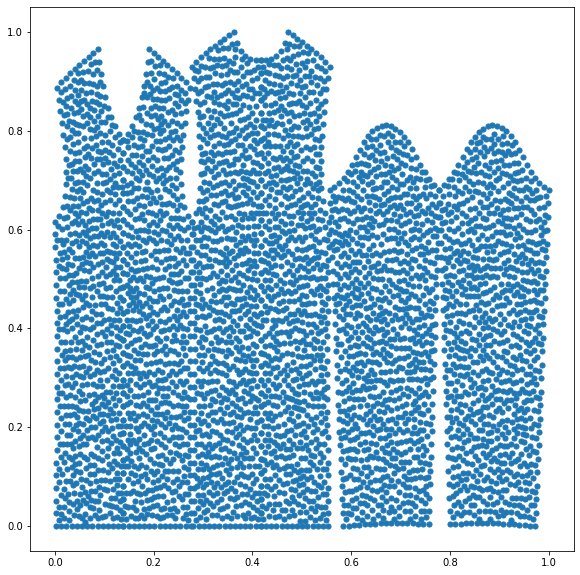

In [34]:
mesh_infos = prepare_mesh(mesh_tshirt)
fig = show_graph(None, [mesh_infos.verts_uvs], None, figsize=[17, 10], axis_equal=True, axis_off=False);

### front and back

In [21]:
name = 'front'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);
torch.save(locations, f'./cache/part_{name}.pt')

name = 'back'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);
torch.save(locations, f'./cache/part_{name}.pt')


Number of the points: 1521
Number of the points: 1654


### sleeves

Number of the points: 954


100%|██████████| 1000/1000 [00:02<00:00, 357.57it/s]


Actual time: 31.341385362483564


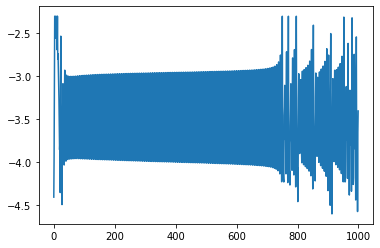

Number of the points: 948


100%|██████████| 1000/1000 [00:02<00:00, 369.17it/s]


Actual time: 50.4661028765142


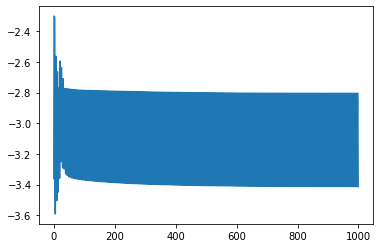

In [9]:
name = 'sleeves1'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);
torch.save(locations, f'./cache/part_{name}.pt')
# fig = show_graph(None, [locations_ori, locations], overlap_set, figsize=[17, 10], axis_equal=True, colors=plt.cm.tab10(4));

name = 'sleeves2'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);
torch.save(locations, f'./cache/part_{name}.pt')
# fig = show_graph(None, [locations_ori, locations], overlap_set, figsize=[17, 10], axis_equal=True, colors=plt.cm.tab10(4));

### front + back

Number of the points: 3175


100%|██████████| 1000/1000 [00:02<00:00, 361.57it/s]


Actual time: 73.7684886727482


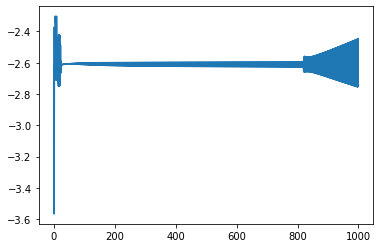

In [7]:
name = 'fandb'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);
torch.save(locations, f'./cache/part_{name}.pt')
# fig = show_graph(adj, [locations_ori, locations], overlap_set,  inds_groups=[i.cpu().numpy() for i in [mesh_infos.groups[i] for i in args_tt[name].part_ids]], figsize=[17, 10], axis_equal=False);


### altogether

Number of the points: 5077


100%|██████████| 1000/1000 [00:02<00:00, 343.12it/s]


Actual time: 15.074892684817314


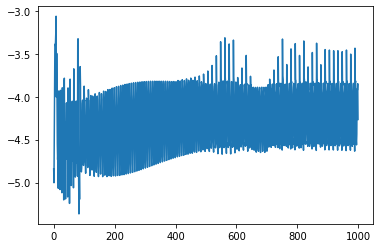

In [10]:
name = 'tshirt_all'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);

In [11]:
loc_o = locations[overlap_set.view(-1)].view(-1, 2, 2)
print((loc_o[:, 1] - loc_o[:, 0]).norm(2, -1).max())

# make sure the overlapped points is exactly the same
loc_sum = torch.zeros_like(locations)
loc_num = torch.zeros(len(locations), device=device)

loc_o = locations[overlap_set.view(-1)].view(-1, 2, 2)
loc_o = loc_o + loc_o.flip(1)

loc_sum.index_put_((overlap_set.view(-1), ), loc_o.view(-1, 2), accumulate=True)
loc_num.index_put_((overlap_set.view(-1), ), torch.ones(loc_o.view(-1, 2).shape[0], device=device), accumulate=True)

loc_sum = (loc_sum - (loc_num.unsqueeze(-1) - 1) * locations) / (loc_num.unsqueeze(-1) + 1)
locations[loc_num>0] = loc_sum[loc_num>0]

for os in overlap_set:
    locations[os[0]] = locations[os[1]]
    
loc_o = locations[overlap_set.view(-1)].view(-1, 2, 2)
print((loc_o[:, 1] - loc_o[:, 0]).norm(2, -1).max())

tensor(0.0167, device='cuda:0')
tensor(0., device='cuda:0')


In [ ]:
# torch.save(locations, f'./cache/part_{name}.pt')
torch.save(locations, f'./cache/part_all_2p5.pt')
# fig = show_graph(adj, [locations_ori, locations], overlap_set,  inds_groups=[i.cpu().numpy() for i in [mesh_infos.groups[i] for i in args_tt[name].part_ids]], figsize=[17, 10], axis_equal=False);

## trouser 

### def

In [27]:
def loc_init_trouser_part(ids, locations, device):
    # initialize the locations for legs
    # ids for 0---3 , reverse for groups[1] and groups[2]
    #         |   |
    #         |   |
    #         |   |
    #         1---2
    # 36, 119, 137, 214 | 3810, 3727, 3705(3977), 3901| [105, 22, 0(272), 196], |(19-35), (3828-3811)
    # 37, 120, 138, 215 | 3799, 3716, 3694(3966), 3890| [105, 22, 0(272), 196], |...

    # ids = [36, 119, 137, 214]
    # ids = [105, 22, 0, 196]
    # ids = [37, 120, 138, 215]
    # ids = [105, 22, 0, 196]

    # locations[:, 0] = locations[:, 0] - locations[:, 0].mean()
    locations[:, 0] = locations[:, 0] - (locations[ids[1], 0] + locations[ids[2], 0]) / 2
    locations[:, 1] = locations[:, 1] - locations[:, 1].min()
    theta0 = np.pi / 2 * 0.95
    # locations[:, 0] *= (locations[:, 1] + 0.2)
    m = 0
    b = (locations[ids[3], 0] - locations[ids[2], 0]) / (locations[ids[3], 1] - locations[ids[2], 1]) / theta0
    a = (locations[ids[2], 0] - locations[ids[2], 1] * b) / theta0
    R = (a + locations[:, 1] * b).abs()
    theta =  (locations[:, 0] - m) / R
    # r = a * (R^2 - R0^2) ^ 1/2
    gamma = 1.0
    R0 = R.min() ** gamma
    R1 = R.max() ** gamma
    r0 = torch.tensor(0.5, device=device) ** gamma
    r1 = torch.tensor(4.0, device=device) ** gamma
    b = R0 - (R1 - R0) / (r1/r0 -1)
    a = r0 / (R0 - b)
    r = (a * (R**gamma - b)) ** (1 / gamma)
    locations = torch.stack([r * theta.sin(), r * theta.cos()], 1)
    locations_ori = locations.clone()
    return locations, locations_ori

def loc_init_trouser_all(locations, device):
    offset = 3.4
    locations1 = torch.load('./cache/part_p0.pt')
    locations2 = -torch.load('./cache/part_p1.pt')
    locations3 = torch.load('./cache/part_p2.pt')
    locations4 = -torch.load('./cache/part_p3.pt')
    locations1[:, 0] -= offset
    locations2[:, 0] -= offset
    locations3[:, 0] += offset
    locations4[:, 0] += offset

    locations = torch.cat([locations1, locations2, locations3, locations4], 0)
    locations_ori = locations.clone()
    return locations, locations_ori


args_optim = {
    'alpha' : [0.1, 0.1],
    'beta' : 10.0,
    'gamma' : 0.5,
    'step_size_max' : 0.1,
    'steps' : 1000,
    'overlap_md' : 1e-3,
    'accumulate_overlap' : True,
}

args_tt = EasyDict({
    'p0':{
        'part_ids': [0],
        'if_skip_move': True,
        'init_fun': partial(loc_init_trouser_part, [36, 119, 137, 214]),
    },
    'p1':{
        'part_ids': [1],
        'if_skip_move': True,
        'init_fun': partial(loc_init_trouser_part, [105, 22, 0, 196]),
    },
    'p2':{
        'part_ids': [2],
        'if_skip_move': True,
        'init_fun': partial(loc_init_trouser_part, [37, 120, 138, 215]),
    },
    'p3':{
        'part_ids': [3],
        'if_skip_move': True,
        'init_fun': partial(loc_init_trouser_part, [105, 22, 0, 196]),
        
    },
    'trouser_all':{
        'part_ids': [0, 1, 2, 3],
        'init_fun': loc_init_trouser_all,
        'bin_size': 1000,
    },
})
print('Done')

Done


Ends in 8 iters
Devided in 4 groups


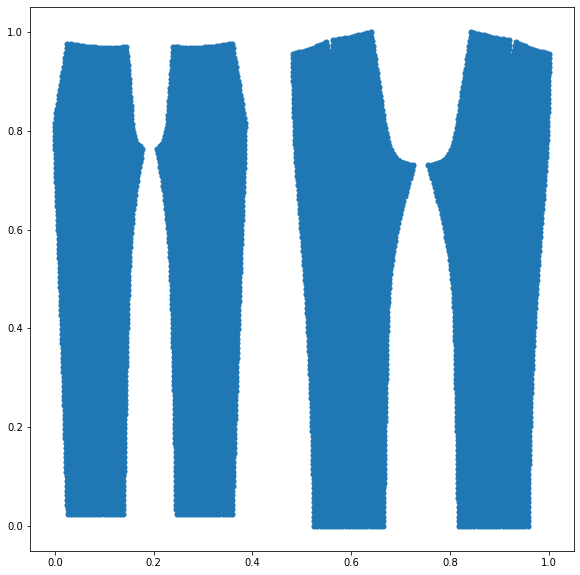

In [12]:
mesh_infos = prepare_mesh(mesh_trouser)
fig = show_graph(None, [mesh_infos.verts_uvs], None, figsize=[17, 10], axis_equal=True, axis_off=False);

### pieces

In [19]:
for name in ['p0', 'p1', 'p2', 'p3']:
    locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);
    torch.save(locations, f'./cache/part_{name}.pt')
    
# fig = show_graph(None, [locations_ori, locations], overlap_set[overlap_set[:, 0]<120], figsize=[17, 10], axis_equal=True, s=3);


Number of the points: 3705
Skip Zipping
Number of the points: 4682
Skip Zipping
Number of the points: 3694
Skip Zipping
Number of the points: 4702
Skip Zipping


### together

Number of the points: 16783


100%|██████████| 1000/1000 [00:03<00:00, 318.63it/s]


Actual time: 17.840794843703044


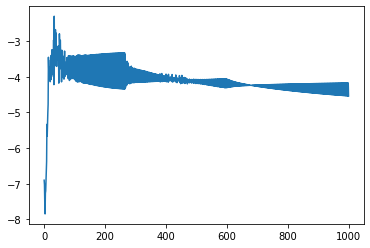

In [30]:
name = 'trouser_all'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device);

In [31]:
loc_o = locations[overlap_set.view(-1)].view(-1, 2, 2)
print((loc_o[:, 1] - loc_o[:, 0]).norm(2, -1).max())
# make sure the overlapped points is exactly the same
loc_sum = torch.zeros_like(locations)
loc_num = torch.zeros(len(locations), device=device)

loc_o = locations[overlap_set.view(-1)].view(-1, 2, 2)
loc_o = loc_o + loc_o.flip(1)

loc_sum.index_put_((overlap_set.view(-1), ), loc_o.view(-1, 2), accumulate=True)
loc_num.index_put_((overlap_set.view(-1), ), torch.ones(loc_o.view(-1, 2).shape[0], device=device), accumulate=True)

loc_sum = (loc_sum - (loc_num.unsqueeze(-1) - 1) * locations) / (loc_num.unsqueeze(-1) + 1)
locations[loc_num>0] = loc_sum[loc_num>0]

for os in overlap_set:
    locations[os[0]] = locations[os[1]]
    
loc_o = locations[overlap_set.view(-1)].view(-1, 2, 2)
print((loc_o[:, 1] - loc_o[:, 0]).norm(2, -1).max())

tensor(0.0695, device='cuda:0')
tensor(0., device='cuda:0')


In [32]:
# torch.save(locations, f'./cache/part_{name}.pt')
torch.save(locations, f'./cache/part_all_off3p4.pt')
# fig = show_graph(adj, [locations_ori, locations], overlap_set,  inds_groups=[i.cpu().numpy() for i in [mesh_infos.groups[i] for i in args_tt[name].part_ids]], figsize=[17, 10], axis_equal=False);
# fig = show_graph(None, [locations], overlap_set, figsize=[17, 10], axis_equal=True, s=3);

# build gift

Number of the points: 954


100%|██████████| 1000/1000 [00:02<00:00, 344.09it/s]


Actual time: 31.341385362483564


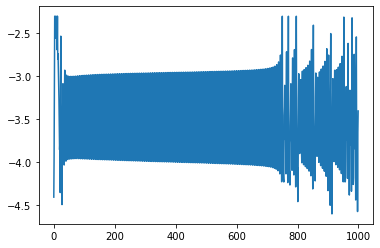

In [37]:
name = 'sleeves1'
locations, locations_ori, info, adj, overlap_set = pipeline(name, args_tt[name], args_optim, mesh_infos, device, retrieve_history=True);
# torch.save(locations, f'./cache/part_{name}.pt')
# fig = show_graph(None, [locations_ori, locations], overlap_set, figsize=[17, 10], axis_equal=True, colors=plt.cm.tab10(4));


In [ ]:
import imageio
images = []

for i in range(10):
    x = info["locations_history"][i]
    fig = show_graph(adj, [x], overlap_set, figsize=[7, 7], axis_equal=True, colors=plt.cm.tab10(4));
    plt.title(f"{i}")
    plt.show()  
#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image = np.array(fig[0].canvas.buffer_rgba())
    images.append(image)
    plt.close()
imageio.mimsave('./cache/movie.gif', images, fps=3)


# End